<a href="https://colab.research.google.com/github/suakow/stock_price_prediction_lstm_practice/blob/master/stock_price_lstm_gru_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [1]:
! pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=150a354c0443843a5f8e9aa8bf1d80b3f6b0273b8b1699de0acaff735f231875
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
import pandas as pd

bgr_df = pd.read_csv('https://raw.githubusercontent.com/suakow/stock_price_prediction_lstm_practice/master/bgr.us.txt')

time: 347 ms


In [3]:
bgr_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,12.130,12.233,11.991,12.115,287699,0
1,2005-02-28,12.147,12.208,12.109,12.158,196150,0
2,2005-03-01,12.158,12.183,12.081,12.141,155314,0
3,2005-03-02,12.176,12.233,12.135,12.170,124179,0
4,2005-03-03,12.141,12.277,12.120,12.246,225421,0


time: 25.1 ms


In [4]:
bgr_df.shape

(3201, 7)

time: 5.99 ms


In [5]:
bgr_df['Date'] = pd.to_datetime(bgr_df['Date'])
bgr_df.set_index('Date', inplace=True)

time: 6.21 ms


In [6]:
bgr_df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,12.130,12.233,11.991,12.115,287699,0
2005-02-28,12.147,12.208,12.109,12.158,196150,0
2005-03-01,12.158,12.183,12.081,12.141,155314,0
2005-03-02,12.176,12.233,12.135,12.170,124179,0
2005-03-03,12.141,12.277,12.120,12.246,225421,0


time: 15.8 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


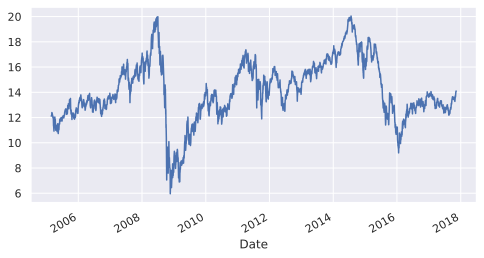

time: 490 ms


In [7]:
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set(rc={'figure.figsize':(8, 4)})

bgr_df['Close'].plot()

# Prepare Data for LSTM

Min-Max Normalisation

In [8]:
bgr_df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,12.130,12.233,11.991,12.115,287699,0
2005-02-28,12.147,12.208,12.109,12.158,196150,0
2005-03-01,12.158,12.183,12.081,12.141,155314,0
2005-03-02,12.176,12.233,12.135,12.170,124179,0
2005-03-03,12.141,12.277,12.120,12.246,225421,0


time: 22.4 ms


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

bgr_close_scaled_np = scaler.fit_transform(bgr_df[['Close']])

time: 66.5 ms


In [10]:
bgr_close_scaled_np[:3]

array([[0.4369699 ],
       [0.44002444],
       [0.43881683]])

time: 2.72 ms


Size transformation

In [11]:
import numpy as np
window_size = 10

X = []
y = []

for _ in np.arange(window_size, len(bgr_close_scaled_np)) :
    X_window_data = [ x for x in bgr_close_scaled_np[_ - window_size : _] ]
    X.append(X_window_data)
    y.append(bgr_close_scaled_np[_])

X = np.array(X)
y = np.array(y)

time: 32.7 ms


In [12]:
X.shape
y.shape

(3191, 1)

time: 2.8 ms


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

time: 51.7 ms


In [14]:
X_train.shape

(2552, 10, 1)

time: 2.61 ms


In [15]:
y_train.shape

(2552, 1)

time: 4.19 ms


# Modeling LSTM

In [53]:
import tensorflow as tf

def build_lstm_model(input, loss='mse', optimiser='adam') :
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input.shape[1], input.shape[2])))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(32, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    # model.add(tf.keras.layers.Dense(32, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.2))
    # model.add(tf.keras.layers.Dense(16, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.2))
    # model.add(tf.keras.layers.Dense(8, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss=loss, optimizer=optimiser)

    return model

time: 17.5 ms


In [54]:
model = build_lstm_model(X_train)

time: 1.11 s


In [55]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 128)           66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [56]:
model_history = model.fit(X_train, y_train, epochs=50, batch_size=25, verbose=2, shuffle=False, validation_split=0.05)

Epoch 1/50
97/97 - 1s - loss: 0.0196 - val_loss: 0.0076
Epoch 2/50
97/97 - 1s - loss: 0.0167 - val_loss: 0.0071
Epoch 3/50
97/97 - 1s - loss: 0.0171 - val_loss: 0.0165
Epoch 4/50
97/97 - 1s - loss: 0.0214 - val_loss: 0.0227
Epoch 5/50
97/97 - 1s - loss: 0.0174 - val_loss: 0.0128
Epoch 6/50
97/97 - 1s - loss: 0.0113 - val_loss: 0.0117
Epoch 7/50
97/97 - 1s - loss: 0.0121 - val_loss: 0.0070
Epoch 8/50
97/97 - 1s - loss: 0.0064 - val_loss: 0.0050
Epoch 9/50
97/97 - 1s - loss: 0.0079 - val_loss: 0.0043
Epoch 10/50
97/97 - 1s - loss: 0.0053 - val_loss: 0.0038
Epoch 11/50
97/97 - 1s - loss: 0.0048 - val_loss: 0.0035
Epoch 12/50
97/97 - 1s - loss: 0.0046 - val_loss: 0.0024
Epoch 13/50
97/97 - 1s - loss: 0.0048 - val_loss: 0.0050
Epoch 14/50
97/97 - 1s - loss: 0.0043 - val_loss: 0.0022
Epoch 15/50
97/97 - 1s - loss: 0.0049 - val_loss: 0.0036
Epoch 16/50
97/97 - 1s - loss: 0.0042 - val_loss: 0.0040
Epoch 17/50
97/97 - 1s - loss: 0.0041 - val_loss: 0.0028
Epoch 18/50
97/97 - 1s - loss: 0.0036 - 

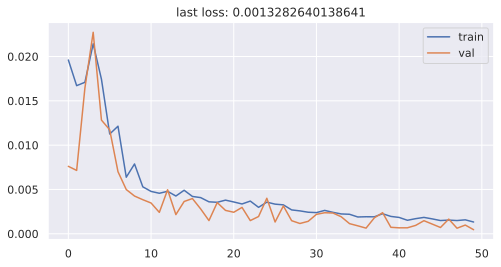

time: 203 ms


In [57]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='val')
plt.legend()
plt.title('last loss: ' + str(model.history.history['loss'][-1]))
plt.show()

In [58]:
y_pred = model.predict(X_test)

time: 1.09 s


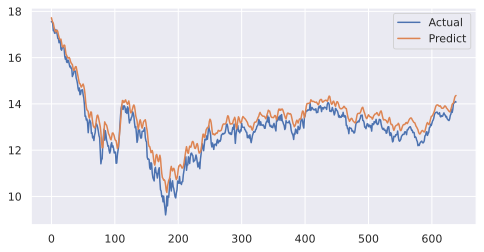

time: 223 ms


In [59]:
import matplotlib.pyplot as plt

plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predict')
plt.legend()
plt.show()

# Modeling GRU

In [60]:
def build_gru_model(input, loss='mse', optimiser='adam') :
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input.shape[1], input.shape[2])))
    model.add(tf.keras.layers.GRU(128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.GRU(64, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.GRU(32, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss=loss, optimizer=optimiser)

    return model

time: 10.9 ms


In [61]:
model = build_gru_model(X_train)

time: 638 ms


In [62]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 10, 128)           50304     
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 10, 64)            37248     
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [63]:
model_history = model.fit(X_train, y_train, epochs=50, batch_size=25, verbose=2, shuffle=False, validation_split=0.05)

ERROR! Session/line number was not unique in database. History logging moved to new session 59
Epoch 1/50
97/97 - 1s - loss: 0.0163 - val_loss: 0.0016
Epoch 2/50
97/97 - 1s - loss: 0.0096 - val_loss: 0.0064
Epoch 3/50
97/97 - 1s - loss: 0.0082 - val_loss: 0.0017
Epoch 4/50
97/97 - 1s - loss: 0.0072 - val_loss: 8.2757e-04
Epoch 5/50
97/97 - 1s - loss: 0.0066 - val_loss: 0.0019
Epoch 6/50
97/97 - 1s - loss: 0.0069 - val_loss: 0.0012
Epoch 7/50
97/97 - 1s - loss: 0.0049 - val_loss: 0.0018
Epoch 8/50
97/97 - 1s - loss: 0.0051 - val_loss: 0.0019
Epoch 9/50
97/97 - 1s - loss: 0.0042 - val_loss: 6.8795e-04
Epoch 10/50
97/97 - 1s - loss: 0.0043 - val_loss: 0.0016
Epoch 11/50
97/97 - 1s - loss: 0.0044 - val_loss: 0.0021
Epoch 12/50
97/97 - 1s - loss: 0.0032 - val_loss: 0.0012
Epoch 13/50
97/97 - 1s - loss: 0.0043 - val_loss: 0.0035
Epoch 14/50
97/97 - 1s - loss: 0.0036 - val_loss: 5.2192e-04
Epoch 15/50
97/97 - 1s - loss: 0.0032 - val_loss: 8.4951e-04
Epoch 16/50
97/97 - 1s - loss: 0.0029 - val

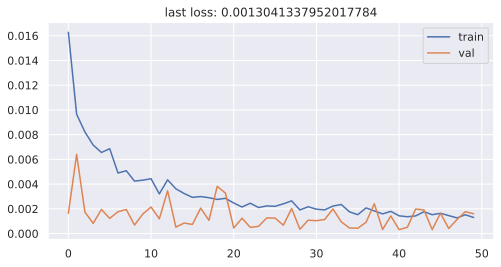

time: 550 ms


In [64]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='val')
plt.legend()
plt.title('last loss: ' + str(model.history.history['loss'][-1]))
plt.show()

In [65]:
y_pred = model.predict(X_test)

time: 728 ms


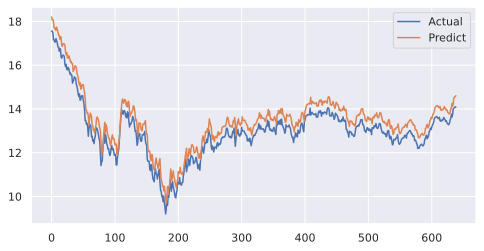

time: 212 ms


In [66]:
plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predict')
plt.legend()
plt.show()

# Modelling RNN

In [67]:
def build_rnn_model(input, loss='mse', optimiser='adam') :
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input.shape[1], input.shape[2])))
    model.add(tf.keras.layers.SimpleRNN(128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.SimpleRNN(64, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.SimpleRNN(32, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss=loss, optimizer=optimiser)

    return model

time: 16.4 ms


In [68]:
model = build_rnn_model(X_train)

time: 224 ms


In [69]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 10, 128)           16640     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 10, 64)            12352     
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)               

In [70]:
model_history = model.fit(X_train, y_train, epochs=50, batch_size=25, verbose=2, shuffle=False, validation_split=0.05)

Epoch 1/50
97/97 - 3s - loss: 0.2801 - val_loss: 0.0288
Epoch 2/50
97/97 - 2s - loss: 0.0781 - val_loss: 0.0271
Epoch 3/50
97/97 - 2s - loss: 0.0572 - val_loss: 0.0350
Epoch 4/50
97/97 - 3s - loss: 0.0323 - val_loss: 0.0206
Epoch 5/50
97/97 - 2s - loss: 0.0236 - val_loss: 0.0252
Epoch 6/50
97/97 - 2s - loss: 0.0192 - val_loss: 0.0187
Epoch 7/50
97/97 - 2s - loss: 0.0152 - val_loss: 0.0056
Epoch 8/50
97/97 - 3s - loss: 0.0123 - val_loss: 0.0070
Epoch 9/50
97/97 - 3s - loss: 0.0119 - val_loss: 0.0065
Epoch 10/50
97/97 - 3s - loss: 0.0102 - val_loss: 0.0051
Epoch 11/50
97/97 - 3s - loss: 0.0101 - val_loss: 0.0044
Epoch 12/50
97/97 - 3s - loss: 0.0080 - val_loss: 0.0051
Epoch 13/50
97/97 - 2s - loss: 0.0079 - val_loss: 0.0026
Epoch 14/50
97/97 - 2s - loss: 0.0075 - val_loss: 0.0029
Epoch 15/50
97/97 - 3s - loss: 0.0069 - val_loss: 0.0039
Epoch 16/50
97/97 - 2s - loss: 0.0061 - val_loss: 0.0044
Epoch 17/50
97/97 - 3s - loss: 0.0057 - val_loss: 0.0030
Epoch 18/50
97/97 - 3s - loss: 0.0056 - 

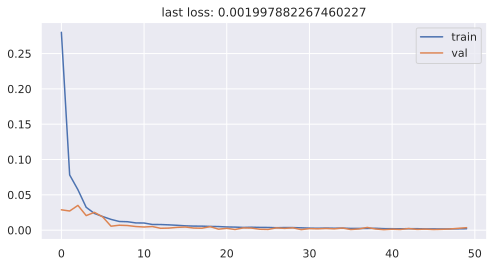

time: 211 ms


In [71]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='val')
plt.legend()
plt.title('last loss: ' + str(model.history.history['loss'][-1]))
plt.show()

In [72]:
y_pred = model.predict(X_test)

time: 299 ms


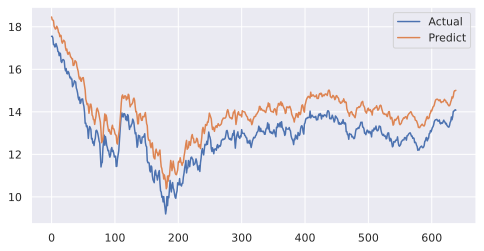

time: 207 ms


In [73]:
plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predict')
plt.legend()
plt.show()